# Wyjaśnienie finalnego modelu

Celem naszego wyjaśnienia jest przede wszystkim jest przyjęcie, bądź odrzucenie hipotezy, jakoby produkty o niższej cenie były przez nas scorowane znacząco wyżej.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import shap

from tqdm import tqdm_notebook as tqdm

In [2]:
train_data = pd.read_pickle("final_data.pkl")

In [3]:
train_data.describe()

,date,offer_id,transactions,category_id,subcategory_id,base_price,week_day
count,1.027677e+06,1.027677e+06,1.027677e+06,1.027677e+06,1.027677e+06,1.027677e+06,1.027677e+06
mean,2.019032e+07,3.557064e+06,8.513452e+00,1.713606e+00,6.327813e+01,2.418807e+02,3.305837e+00
std,8.577087e+00,5.636862e+05,1.280707e+01,1.210694e+00,2.856859e+01,2.220185e+02,2.003275e+00
min,2.019030e+07,3.354560e+05,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+01,0.000000e+00
25%,2.019031e+07,3.281811e+06,2.000000e+00,1.000000e+00,5.900000e+01,1.279000e+02,2.000000e+00
50%,2.019032e+07,3.798514e+06,5.000000e+00,1.000000e+00,6.500000e+01,1.799900e+02,3.000000e+00
75%,2.019032e+07,3.967947e+06,1.000000e+01,2.000000e+00,7.900000e+01,2.990000e+02,5.000000e+00
max,2.019033e+07,4.135417e+06,3.250000e+02,5.000000e+00,1.960000e+02,7.999000e+03,6.000000e+00


In [4]:
train_data.shape

(1027677, 20)

## Odtworzenie zmiennych takich jak w finalnym modelu (uwzględnienie segmentacji jako ciągu reguł decyzyjnych)

In [5]:
def transform_data(data):
    X = data[["landing_page", "device", "channel", "city", "discount_percent", "price"]]
    X = X[X["price"].apply(lambda x: False if x.find(",") > -1 else True)]
    X = X[X["discount_percent"].apply(lambda x: False if x.find("%") > -1 else True)]
    X = X.copy()
    X["butyInLandingPage"] = X["landing_page"].apply(lambda x: True if x.find("buty") >= 0  else False).astype(int)
    X["isDeviceMobile"] = X["device"].apply(lambda x: True if x == "mobile" else False).astype(int)
    X["channelContainsPaid"]= X["channel"].apply(lambda x: True if x.find("Paid") >= 0 else False).astype(int)
    X["isBigCity"] = X["city"].apply(lambda x: True if x in {"Warsaw", "Krakow", "Lodz", "Wroclaw", "Poznan", "Gdansk", "Szczecin", "Bydgoszcz"} else False).astype(int)

    return X[["butyInLandingPage", "isDeviceMobile", "channelContainsPaid", "isBigCity", "discount_percent", "price"]].astype(float)

Nowe zmienne mają związek z regułami na podstawie których dokonano segmentacji.

In [6]:
transformed_data = transform_data(train_data)

Funkcja scorująca - w dwóch wersjach (jedna wymagana przez KernelExplainer z pakietu SHAP).

In [7]:
def calculate_scores(X):
    new_df = X.copy()
    segment_score = np.empty(X.shape[0])
    # segment 1
    map1 = X["butyInLandingPage"] == 1
    segment_score[map1] = 0.859
    act_map = ~map1
    # segment 2
    map2 = X["isDeviceMobile"] == 1
    segment_score[np.logical_and(act_map, map2)] = 0.565
    act_map = np.logical_and(act_map, ~map2)
    # segment 3
    map3 = X["channelContainsPaid"] == 1
    segment_score[np.logical_and(act_map, map3)] = 0.852
    act_map = np.logical_and(act_map, ~map3)
    # segment 4
    map4 = X["isBigCity"] == 1
    segment_score[np.logical_and(act_map, map4)] = 0.632
    act_map = np.logical_and(act_map, ~map4)
    # segment 5
    segment_score[act_map] = 0.756
    
    new_df["segment_score"] = segment_score
    new_df["price"] = X["price"].astype(np.float)
    new_df["discount_percent"] = X["discount_percent"].astype(np.float)
    
    scores = 1 / (1 + np.exp(new_df["price"]*2.08804302e-03 + new_df["discount_percent"]*7.07348740e-03 + new_df["segment_score"]*2.10985824 + 2.829846))
    return scores

In [8]:
def calculate_scores_for_shap(X):
    new_df = X.copy()
    segment_score = np.empty(X.shape[0])
    # segment 1
    map1 = X[:, 0] == 1
    segment_score[map1] = 0.859
    act_map = ~map1
    # segment 2
    map2 = X[:, 1] == 1
    segment_score[np.logical_and(act_map, map2)] = 0.565
    act_map = np.logical_and(act_map, ~map2)
    # segment 3
    map3 = X[:, 2] == 1
    segment_score[np.logical_and(act_map, map3)] = 0.852
    act_map = np.logical_and(act_map, ~map3)
    # segment 4
    map4 = X[:, 3] == 1
    segment_score[np.logical_and(act_map, map4)] = 0.632
    act_map = np.logical_and(act_map, ~map4)
    # segment 5
    segment_score[act_map] = 0.756
    
    prices = X[:, 5].astype(float)
    discount_size = X[:, 4].astype(float)

    scores = 1 / (1 + np.exp(prices*2.08804302e-03 + discount_size*7.07348740e-03 + segment_score*2.10985824 + 2.829846))
    return scores

## Wyjaśnienie SHAP

Budowa modelu SHAP na wszystkich zmiennych powodowała olbrzymi czas obliczeń. Stąd konieczność wylosowania próbki 2000 tys. obserwacji.

In [9]:
transformed_data2 = transformed_data.sample(2000).values.astype(np.float)

In [10]:
explainer = shap.KernelExplainer(calculate_scores_for_shap, transformed_data2)

Using 2000 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [11]:
shap_values = explainer.shap_values(transformed_data2, l1_reg="aic")

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [13:30<00:00,  2.15it/s]


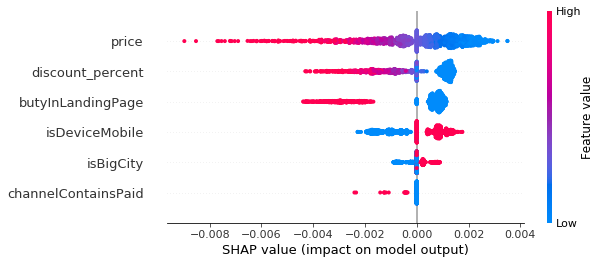

In [12]:
shap.summary_plot(shap_values, transformed_data2, feature_names=["butyInLandingPage", "isDeviceMobile", "channelContainsPaid", "isBigCity", "discount_percent", "price"])

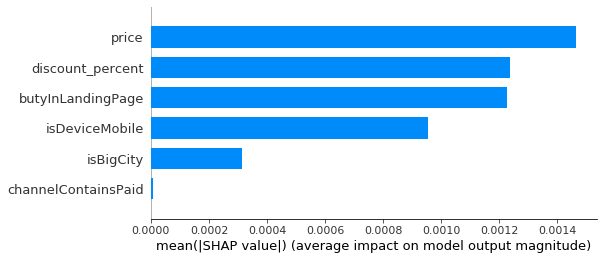

In [13]:
shap.summary_plot(shap_values, transformed_data2, plot_type="bar", feature_names=["butyInLandingPage", "isDeviceMobile", "channelContainsPaid", "isBigCity", "discount_percent", "price"])

Zaobserwować możemy, że cena jest najistotniejszą zmiennę i faktycznie niższa cena powoduje wyższą ocenę.

Patrząc na wykres SHAP, można dojść do wniosku, że zarówno dane według których dokonano segmentacji, jak i zmienne objaśniające są istotne i wpływaja na finalny scoring w sposób wręcz monotoniczny.

## Krzywe PDP + CP

In [14]:
transformed_data = transformed_data.astype(np.float)

In [17]:
def plot_dp(function, df, feature, nPoints, size=5000):
    sns.set(rc={'figure.figsize':(15,12)})
    sns.set_style("whitegrid")
    sns.set_context("notebook")
    featureRange = (df.loc[:, feature].min(), df.loc[:, feature].max())
    x = np.linspace(featureRange[0], featureRange[1], num=nPoints, endpoint=True)
    y_cum = []
    df_columns = df.columns
    for row_index in tqdm(range(df.sample(size).shape[0])):
        sample = pd.DataFrame(columns=df_columns)
        sample.loc[0] = df.iloc[row_index, :]
        samples = sample.append([sample.iloc[0, :]]*(nPoints-1), ignore_index=True).reset_index(drop=True)
        samples.loc[:, feature] = x
        y = function(samples)
        y_cum.append(y)
        plt.plot(x, y, color="gray", linewidth=0.5, alpha = 0.4)
        sample_x = sample.loc[:, feature]
        sample_prob = function(sample)
        plt.plot(sample_x, sample_prob, "o", markersize=3, color="black", alpha=0.6)
    y_cum = np.array(y_cum).mean(axis=0)
    plt.plot(x, y_cum, color="navy", linewidth=5)
    plt.ylabel("Result")
    plt.title("PDP curve for {}".format(feature))

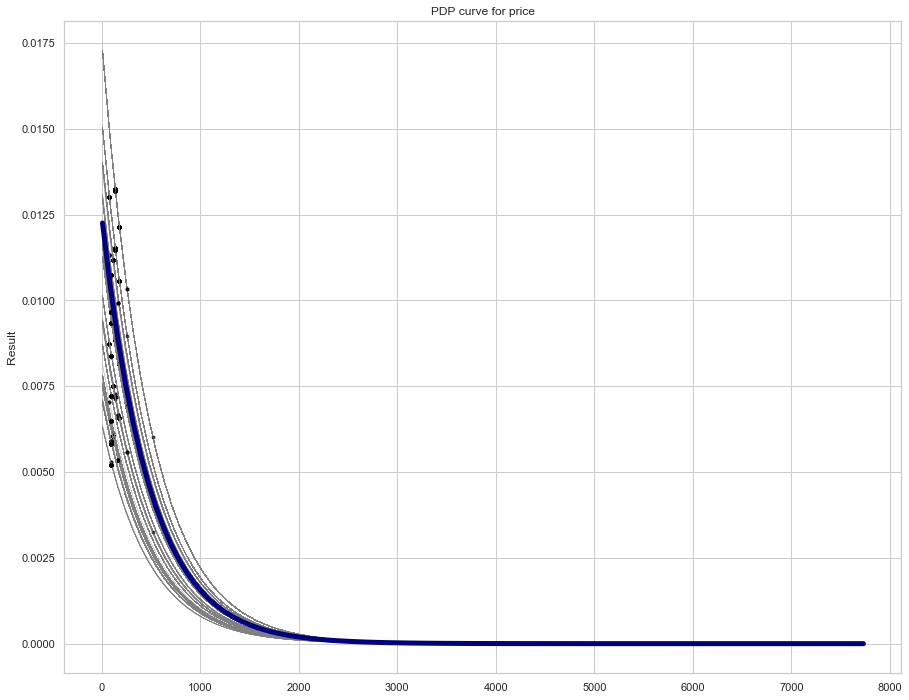

In [18]:
plot_dp(calculate_scores, transformed_data, "price", 100)

Ponownie - zauważyć można tendencję, że produkty o niższej cenie dostają wyższą ocenę.

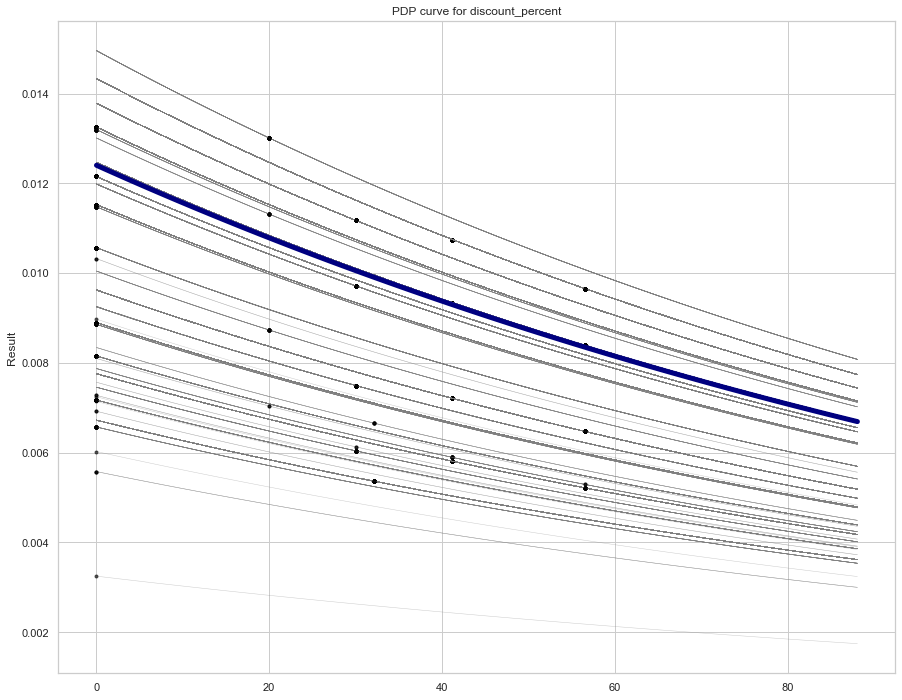

In [19]:
plot_dp(calculate_scores, transformed_data, "discount_percent", 100)

## Wykresy Break Down dla ciekawych próbek

Spojrzenie na pojedyncze próbki - w tym wypadku te o najwyższym scoringu.

In [83]:
def plot_break_down(function, df, sample, features_path, ax):
    modDf = df.copy()
    y = function(modDf)
    resultDf = pd.DataFrame(data = {"Prob": y, "step": "all data"})
    for feature in features_path:
        value_of_feature = sample.loc[0, feature]
        modDf[feature] = value_of_feature
        y = function(modDf)
        resultDf = resultDf.append(pd.DataFrame(data = {"Prob": y, "step": "+ {} = {:0.2f}".format(feature, value_of_feature)}), ignore_index=True)
    steps = resultDf["step"].unique()[::-1]
    sns.violinplot(data = resultDf,  x="Prob", y="step", inner=None, order=steps, ax=ax, color = "white")
    means = []
    for i, step in enumerate(steps):
        mean = resultDf.loc[resultDf["step"]==step].loc[:, "Prob"].mean()
        ax.plot(mean, i, "o", color="firebrick", markersize=10)
        ax.text(mean + 0.0015, i - 0.01, "{:0.3f}".format(mean))
        means.append(mean)
    for i in range(len(steps)-2, -1, -1):
        diff = means[i]-means[i+1]
        color = "darkgreen" if diff >= 0 else "darkred"
        ax.text(0.02, i, "{:+0.5f}".format(diff), color = color)
    ax.grid(axis="y")
    ax.set_ylabel("")
    ax.set_xlabel("")

In [84]:
def plot_compare_break_down(calculate_scores, transformed_data, sample, order1, order2):
    sns.set(rc={'figure.figsize':(9,12)})
    sns.set_style("darkgrid")
    sns.set_context("notebook", font_scale=1.1)

    fig, axes = plt.subplots(2, 1)

    plot_break_down(calculate_scores, transformed_data, sample, order1, axes[0])
    plot_break_down(calculate_scores, transformed_data, sample, order2, axes[1])

    axes[0].set_title("Break Down Plots", fontsize = 15)
    axes[1].set_xlabel("Score")
    plt.show()

In [85]:
sorted_data = transformed_data.copy()
sorted_data["scores"] = calculate_scores(transformed_data)

In [86]:
sorted_data = sorted_data.sort_values("scores", ascending=False)

In [87]:
sample1 = pd.DataFrame(sorted_data.iloc[0, :]).transpose().reset_index(drop=True)
sample2 = pd.DataFrame(sorted_data.iloc[1, :]).transpose().reset_index(drop=True)
sample3 = pd.DataFrame(sorted_data.iloc[2, :]).transpose().reset_index(drop=True)

In [88]:
order1 = ["butyInLandingPage", "isDeviceMobile", "channelContainsPaid", "isBigCity", "discount_percent", "price"]
order2 = order1[::-1]

### Najwyżej oscorowany wynik

In [92]:
sample1

,butyInLandingPage,isDeviceMobile,channelContainsPaid,isBigCity,discount_percent,price,scores
0,0.0,1.0,0.0,0.0,0.0,20.0,0.016895


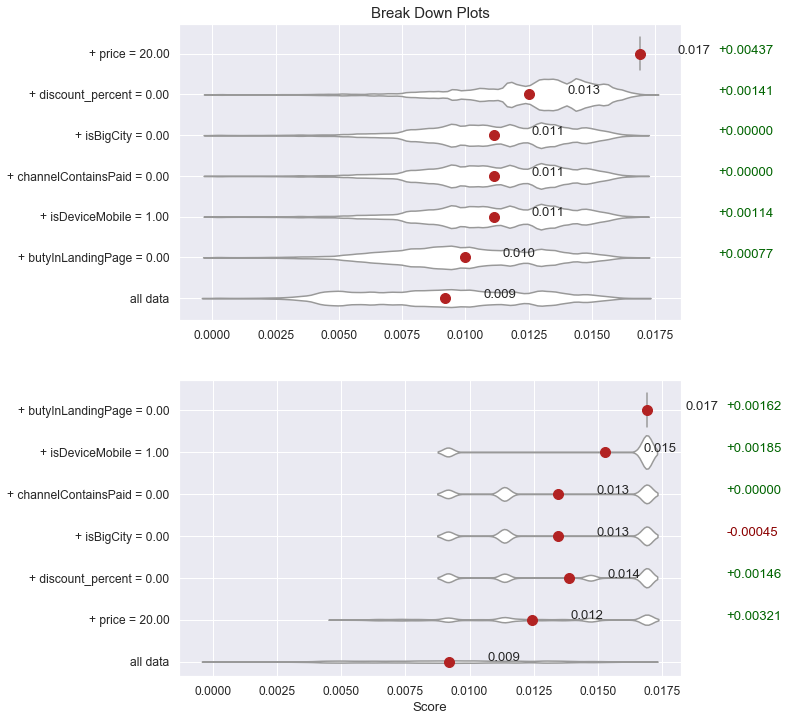

In [89]:
plot_compare_break_down(calculate_scores, transformed_data, sample1, order1, order2)

### Drugi najwyżej oscorowany wynik

In [93]:
sample2

,butyInLandingPage,isDeviceMobile,channelContainsPaid,isBigCity,discount_percent,price,scores
0,0.0,1.0,0.0,1.0,0.0,20.0,0.016895


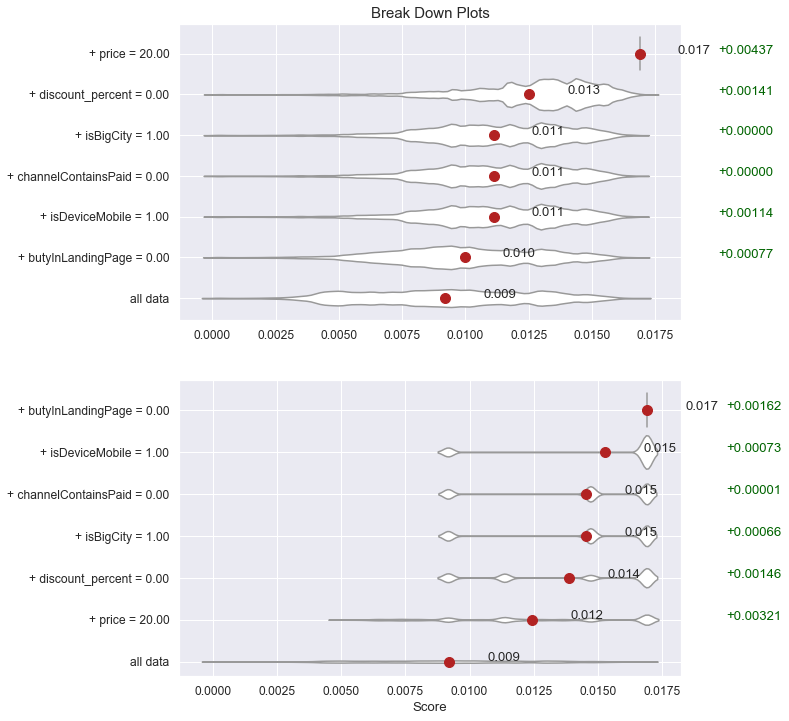

In [90]:
plot_compare_break_down(calculate_scores, transformed_data, sample2, order1, order2)

### I trzeci

In [94]:
sample3

,butyInLandingPage,isDeviceMobile,channelContainsPaid,isBigCity,discount_percent,price,scores
0,0.0,1.0,0.0,1.0,0.0,20.0,0.016895


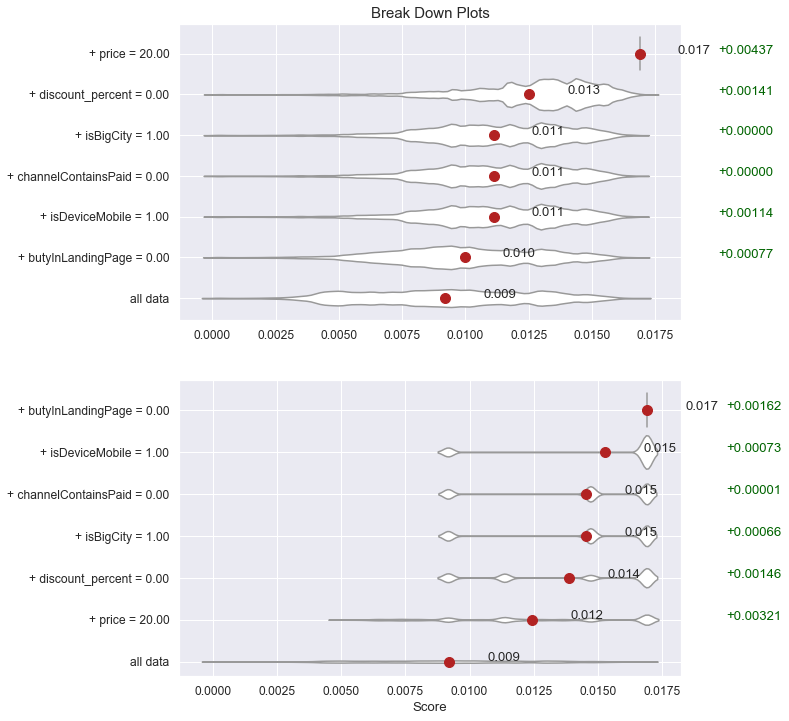

In [91]:
plot_compare_break_down(calculate_scores, transformed_data, sample3, order1, order2)

Wszystkie 3 próbki charakteryzują się relatywnie niewielką ceną, we wszystkich 3 przypadkach podnosi ona finalny scoring.

### Próbka o najniższym scoringu

In [102]:
sample4 = sorted_data.tail(1).reset_index(drop=True)

In [103]:
sample4

,butyInLandingPage,isDeviceMobile,channelContainsPaid,isBigCity,discount_percent,price,scores
0,0.0,0.0,0.0,0.0,0.0,7731.0,1.168483e-09


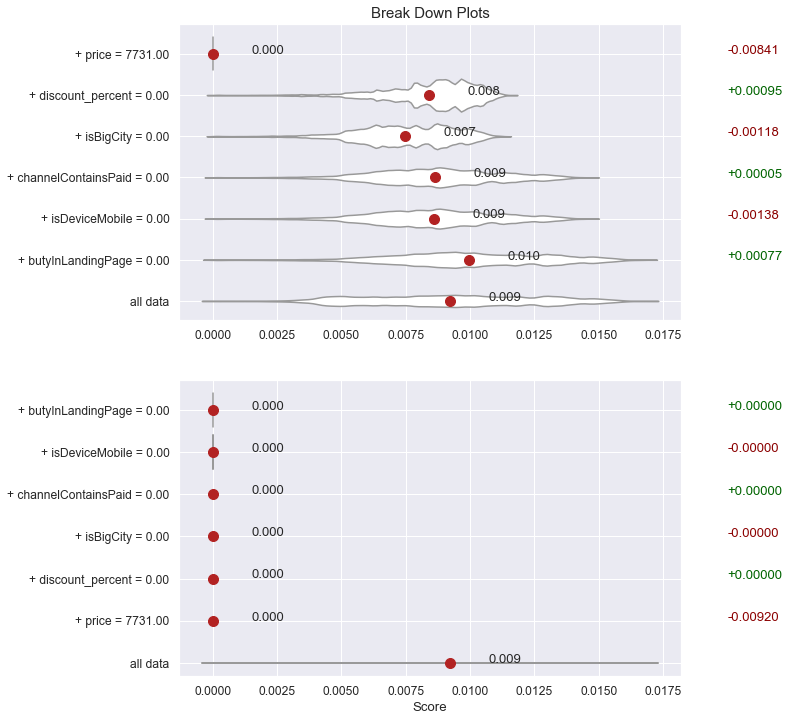

In [104]:
plot_compare_break_down(calculate_scores, transformed_data, sample4, order1, order2)

Próbka o najniższym scoringu charakteruzyje się wysoką ceną (ponad 7 tys. zł!). Dla obu kolejności dokłądania zmiennych cena zdecydowanie przeważa i ściąga finalną ocenę zdecydowanie do 0 (tak, że innne zmienne nie mają nic do powiedzenia). 